# Analyzing how coherence scales with model size

## Importing libraries and loading data

In [69]:
from src.analyzer import Analyzer
from src.visualizer import VisualisationConfig, visualize
from src.metrics import pairwise_bce_of_group
import altair as alt
import numpy as np
import pandas as pd

alt.data_transformers.enable("vegafusion")

logprob_data_paths = ["data/logprobs_part1.csv", "data/logprobs_part2.csv"]

# merge logprobs.csv and pythia_logprobs.csv

logprobs = [pd.read_csv(logprob_data_path) for logprob_data_path in logprob_data_paths]


# merge the two dataframes
logprobs = pd.concat(logprobs)
logprobs.reset_index(drop=True, inplace=True)


data_analyzer = Analyzer(logprobs)
data_analyzer.df

,item_index,class_category,class,class_elicitation,evidence_text,evidence_elicitation,conversation_history,model_name,model_provider,temperature,...,posterior_prob,prior_prompt,likelihood_prompt,posterior_prompt,prior_full_text,likelihood_full_text,posterior_full_text,prior_token_logprobs,likelihood_token_logprobs,posterior_token_logprobs
0,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,a record-tying number of world championships ...,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.064653,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-6.217564105987549, -6.68656063079834, -7.278...","[-1.5588836669921875, -0.008721711114048958, -..."
1,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,breathtaking qualifying laps and legendary we...,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.022107,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-17.018823623657227, -7.016323089599609, -1.0...","[-2.4445810317993164, -0.008835033513605595, -..."
2,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,strategic championship battles with rivals ac...,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.034644,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-14.231816291809082, -8.730987548828125, -3.9...","[-2.106292247772217, -0.0070099132135510445, -..."
3,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,dominant performances in the turbo-hybrid era.,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.073508,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-11.61587905883789, -2.5253348350524902, -2.0...","[-1.3492863178253174, -0.01128622516989708, -1..."
4,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,the youngest ever Formula 1 world champion.,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.130401,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-2.0232248306274414, -9.38841724395752, -2.04...","[-1.1226575374603271, -0.02211189828813076, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106585,9,airlines,Qantas.,I usually fly with,SkyTeam membership with access to a large par...,I prefer an airline

In [70]:
data_analyzer.df.columns

Index(['item_index', 'class_category', 'class', 'class_elicitation',
       'evidence_text', 'evidence_elicitation', 'conversation_history',
       'model_name', 'model_provider', 'temperature', 'device', 'model_params',
       'model_kwargs', 'prior_logprob', 'likelihood_logprob',
       'posterior_logprob', 'prior_num_tokens', 'likelihood_num_tokens',
       'posterior_num_tokens', 'prior_prob', 'likelihood_prob',
       'posterior_prob', 'prior_prompt', 'likelihood_prompt',
       'posterior_prompt', 'prior_full_text', 'likelihood_full_text',
       'posterior_full_text', 'prior_token_logprobs',
       'likelihood_token_logprobs', 'posterior_token_logprobs'],
      dtype='object')

## Renaming columns, models and adding model family and size columns

In [71]:
np.unique(data_analyzer.df["model_name"]), np.unique(data_analyzer.df["model_kwargs"])

(array(['EleutherAI/pythia-12b', 'EleutherAI/pythia-160m',
        'EleutherAI/pythia-1b', 'EleutherAI/pythia-6.9b',
        'Qwen/Qwen2.5-14B', 'Qwen/Qwen2.5-3B', 'Qwen/Qwen2.5-7B',
        'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
        'meta-llama/Llama-3.1-8B', 'meta-llama/Llama-3.2-1B',
        'meta-llama/Llama-3.2-3B', 'microsoft/phi-4',
        'mistralai/Mistral-Nemo-Base-2407', 'openai-community/gpt2',
        'openai-community/gpt2-large', 'openai-community/gpt2-medium',
        'openai-community/gpt2-xl', 'tiiuae/Falcon3-10B-Base',
        'tiiuae/Falcon3-1B-Base', 'tiiuae/Falcon3-3B-Base',
        'tiiuae/Falcon3-7B-Base'], dtype=object),
 array(['{"revision": "step143000"}', '{"revision": "step33000"}',
        '{"revision": "step66000"}', '{"revision": "step99000"}', '{}'],
       dtype=object))

In [72]:
# evals from open-llm-leaderboard
evals_df = pd.read_parquet(
    "hf://datasets/open-llm-leaderboard/contents/data/train-00000-of-00001.parquet"
)
evals_df.columns

Index(['eval_name', 'Precision', 'Type', 'T', 'Weight type', 'Architecture',
       'Model', 'fullname', 'Model sha', 'Average ⬆️', 'Hub License', 'Hub ❤️',
       '#Params (B)', 'Available on the hub', 'MoE', 'Flagged',
       'Chat Template', 'CO₂ cost (kg)', 'IFEval Raw', 'IFEval', 'BBH Raw',
       'BBH', 'MATH Lvl 5 Raw', 'MATH Lvl 5', 'GPQA Raw', 'GPQA', 'MUSR Raw',
       'MUSR', 'MMLU-PRO Raw', 'MMLU-PRO', 'Merged', 'Official Providers',
       'Upload To Hub Date', 'Submission Date', 'Generation', 'Base Model'],
      dtype='object')

In [73]:
data_analyzer.rename({"model_name": "Language Model", "model_kwargs": "Training Steps"})

params_lookup = (
    evals_df.drop_duplicates(subset=["fullname"])
    .set_index("fullname")["#Params (B)"]
    .to_dict()
)

# Add the '#Params (B)' column to data_analyzer.df
data_analyzer.add_column(
    column_name="#Params (B)",
    column_spec=lambda df: df["Language Model"]
    .map(params_lookup)
    .astype(float),  # Ensure it's float for numerical operations
)

selected_evals = [
    "IFEval",
    "BBH",
    "MATH Lvl 5",
    "GPQA",
    "MUSR",
    "MMLU-PRO",
    "MMLU-PRO",
    "Average ⬆️",
]

# Create a lookup dictionary once for efficiency
eval_lookup = {}
for model_name in evals_df["fullname"].unique():
    eval_lookup[model_name] = {
        eval_name: evals_df[evals_df["fullname"] == model_name][eval_name].iloc[0]
        for eval_name in selected_evals
        if not evals_df[evals_df["fullname"] == model_name].empty
    }

# Add columns using direct dictionary lookups
for eval in selected_evals:
    data_analyzer.add_column(
        column_name=eval,
        column_spec=lambda df, eval_name=eval: df["Language Model"].map(
            lambda model: eval_lookup.get(model, {}).get(eval_name, np.nan)
        ),
    )

data_analyzer.add_column(
    column_name="Model Family",
    column_spec=(
        {"Language Model": lambda model_name: model_name.split("/")[1].split("-")[0]}
    ),
)


def format_model_kwargs(kwarg_str):
    if '"revision": "step' in kwarg_str:
        # Extract the step number
        step = kwarg_str.split("step")[1].split('"')[0]
        # Convert to k format (e.g., 33000 -> 33k)
        step_k = str(int(step) // 1000) + "k"
        return step_k
    else:
        return "unknown"
    
    

data_analyzer.filter({"Model Family": ["Llama", "gpt2", "pythia", "Qwen2.5", "Falcon3"]})

data_analyzer.rename(
    {
        "Model Family": {
            "Llama": "Llama 3",
            "gpt2": "GPT 2",
            "pythia": "Pythia",
            "Qwen2.5": "Qwen 2.5",
        },
        "Language Model": lambda model_name: model_name.split("/")[1],
        "Training Steps": format_model_kwargs,
    }
)

data_analyzer.df

,item_index,class_category,class,class_elicitation,evidence_text,evidence_elicitation,conversation_history,Language Model,model_provider,temperature,...,posterior_token_logprobs,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family
0,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,a record-tying number of world championships ...,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-1.5588836669921875, -0.008721711114048958, -...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
1,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,breathtaking qualifying laps and legendary we...,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-2.4445810317993164, -0.008835033513605595, -...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
2,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,strategic championship battles with rivals ac...,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-2.106292247772217, -0.0070099132135510445, -...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
3,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,dominant performances in the turbo-hybrid era.,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-1.3492863178253174, -0.01128622516989708, -1...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
4,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,the youngest ever Formula 1 world champion.,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-1.1226575374603271, -0.02211189828813076, -0...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103355,9,airlines,Qantas.,I usually fly with,SkyTeam membership with access to a large par...,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-4.73833703994751, -0.02424274943768978, -3.0...",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia
103356,9,airlines,Qantas.,I usually fly with,historic roots as a flag carrier representing...,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-6.370099067687988, -0.033004920929670334, -4...",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia
103357,9,airlines,Qantas.,I usually fly with,a strong presence serving cities across North...,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-3.792026996612549, -0.019088616594672203, -3...",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia
103358,9,airlines,Qantas.,I usually fly with,fast Wi-Fi and a generous baggage allowance.,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-5.20582914352417, -0.007504486478865147, -3....",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia


In [84]:
np.unique(data_analyzer.df["conversation_history"])

array(['Earlier today, we compared critical thinking in science, law, and ethics.',
       'Earlier, we discussed how people communicate ideas, whether through speeches, essays, or fiction.',
       'Earlier, we talked about historical periods and how art movements reflect social change.',
       'Earlier, we were discussing famous public figures, including musicians, athletes, and world leaders.',
       'Last time, we explored how external events influence our mental status and how people describe their inner experience.',
       'Last week, we compared iconic movie characters from action films and animation.',
       'Last week, we discussed favorite art forms, such as painting, music, and sculpture.',
       'Now we are examining characteristics and innovations that distinguish types of buildings throughout history.',
       "Now we're reflecting on the main traditions of philosophical thought and how they shape our worldview.",
       "Now, we are considering what makes someone's 

## Calculating BCE (both MSE and MAE methods)

We always group by evidence_text since different class types have different class and evidence elicitation prefixes.

The calculate_metric functions are unique in that they return an Analyzer object rather than modifying the dataframe in place. This allows calculating multiple metrics on the same dataframe. Since the returned object is an Analyzer, we can continue to filter, sort, rename and add columns. 

In [85]:
bce_mse_analyzer = data_analyzer.calculate_metric(
    metric_name="BCE (Pairwise MSE)",
    metric_func=pairwise_bce_of_group,
    group_by_cols=[
        "evidence_text",
        "class_category",
        "Language Model",
        "Training Steps",
        "conversation_history"
    ],
    log_prior_col="prior_logprob",
    log_likelihood_col="likelihood_logprob",
    log_posterior_col="posterior_logprob",
    square=True,
    inherit_identical_values=True,
)

# Set sort order using the *new* names
bce_mse_analyzer.sort(
    {
        "#Params (B)": lambda x: x,
        "Training Steps": [
            "33k",
            "66k",
            "99k",
            "143k",
            "unknown",
        ],
    }
)

bce_mse_analyzer.df.columns

Index(['evidence_text', 'class_category', 'Language Model', 'Training Steps',
       'conversation_history', 'BCE (Pairwise MSE)', 'item_index',
       'class_elicitation', 'evidence_elicitation', 'model_provider',
       'temperature', 'device', 'model_params', 'likelihood_num_tokens',
       'prior_prompt', 'posterior_prompt', '#Params (B)', 'IFEval', 'BBH',
       'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️', 'Model Family'],
      dtype='object')

## Define a visualization config and visualize the data

src.visualizer provides a very simple interface for quickly visualizing lots of data by describing which column to map to which plotting element.

In [86]:
config = VisualisationConfig(
    plot_fn=alt.Chart.mark_line,
    fig_title="BCE (Pairwise MSE method) by Model",
    x_category="Language Model:N",
    y_category="mean(BCE (Pairwise MSE)):Q",
    color_category="Training Steps:N",
    facet_category="Model Family:N",
    facet_columns=10,
    tooltip_fields=[
        alt.Tooltip("Language Model:N", title="Model"),
        alt.Tooltip("Model Family:N", title="Family"),
        alt.Tooltip("mean(BCE (Pairwise MSE)):Q", title="Mean BCE", format=".3f"),
        alt.Tooltip("median():Q", title="Median", format=".3f"),
        alt.Tooltip("mean():Q", title="Mean", format=".3f"),
        alt.Tooltip("count():Q", title="Count", format="d"),
    ],
    titles={
        "mean(BCE (Pairwise MSE)):Q": "Mean BCE (Pairwise MSE method)",
        "model_name": "Language Model",
    },
    chart_properties={"resolve": {"scale": {"x": "independent", "y": "shared"}}},
    legend_config={"columns": 5, "orient": "bottom"},
)

chart_mse = visualize(bce_mse_analyzer.df, config=config)

chart_mse.show()

alt.FacetChart(...)

## Plotting BCE by Model Size (log scale), 

We first get rid of the earlier Pythia checkpoints. 


In [87]:
for analyzer in [bce_mse_analyzer]:
    analyzer.filter({"Training Steps": ["unknown", "143k"]})

np.unique(bce_mse_analyzer.df["Training Steps"])

array(['143k', 'unknown'], dtype=object)

In [88]:
config = VisualisationConfig(
    plot_fn=alt.Chart.mark_point,
    fig_title="BCE (Pairwise MSE method) by Model",
    x_category="GPQA:Q",
    y_category="mean(BCE (Pairwise MSE)):Q",
    color_category="Model Family:N",
    tooltip_fields=[
        alt.Tooltip("Language Model:N", title="Model"),
        alt.Tooltip("Model Family:N", title="Family"),
        alt.Tooltip("mean(BCE (Pairwise MSE)):Q", title="Mean BCE", format=".3f"),
        alt.Tooltip("median():Q", title="Median", format=".3f"),
        alt.Tooltip("mean():Q", title="Mean", format=".3f"),
        alt.Tooltip("count():Q", title="Count", format="d"),
    ],
    titles={
        "mean(BCE (Pairwise MSE)):Q": "Mean BCE (Pairwise MSE method)",
        "model_name": "Language Model",
    },
    scale={
        "Model Size:Q": {"type": "log"},
        "mean(BCE (Pairwise MSE)):Q": {"zero": False},
    },
    chart_properties={
        "resolve": {"scale": {"x": "independent", "y": "shared"}},
    },
    legend_config={"columns": 5, "orient": "bottom"},
)

chart_mse = visualize(bce_mse_analyzer.df, config=config)

chart_mse.show()

alt.Chart(...)

## Plotting without the visualizer for more complex plots

Since we can't rely on the aggregation functions provided by altair, we will need to manually aggregate the data.

In [89]:
mean_bce_mse_analyzer = bce_mse_analyzer.calculate_metric(
    metric_func="mean",
    group_by_cols=["Language Model"],
    metric_col="BCE (Pairwise MSE)",
    metric_name="Mean BCE (Pairwise MSE)",
    inherit_identical_values=True,
)

## Plotting with seaborn

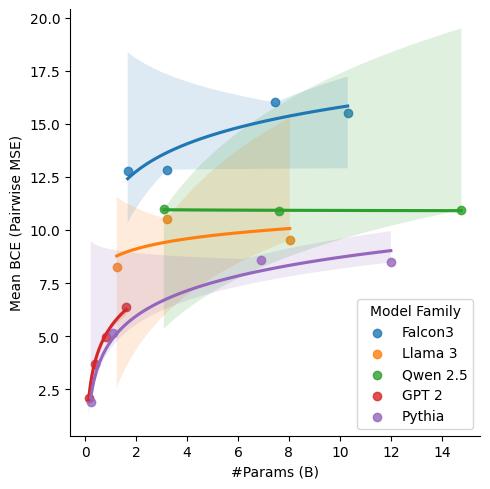

In [90]:
import seaborn as sns

plt = sns.lmplot(
    data=mean_bce_mse_analyzer.df,
    x="#Params (B)",
    y="Mean BCE (Pairwise MSE)",
    hue="Model Family",
    logx=True,
    facet_kws={"legend_out": False},
)

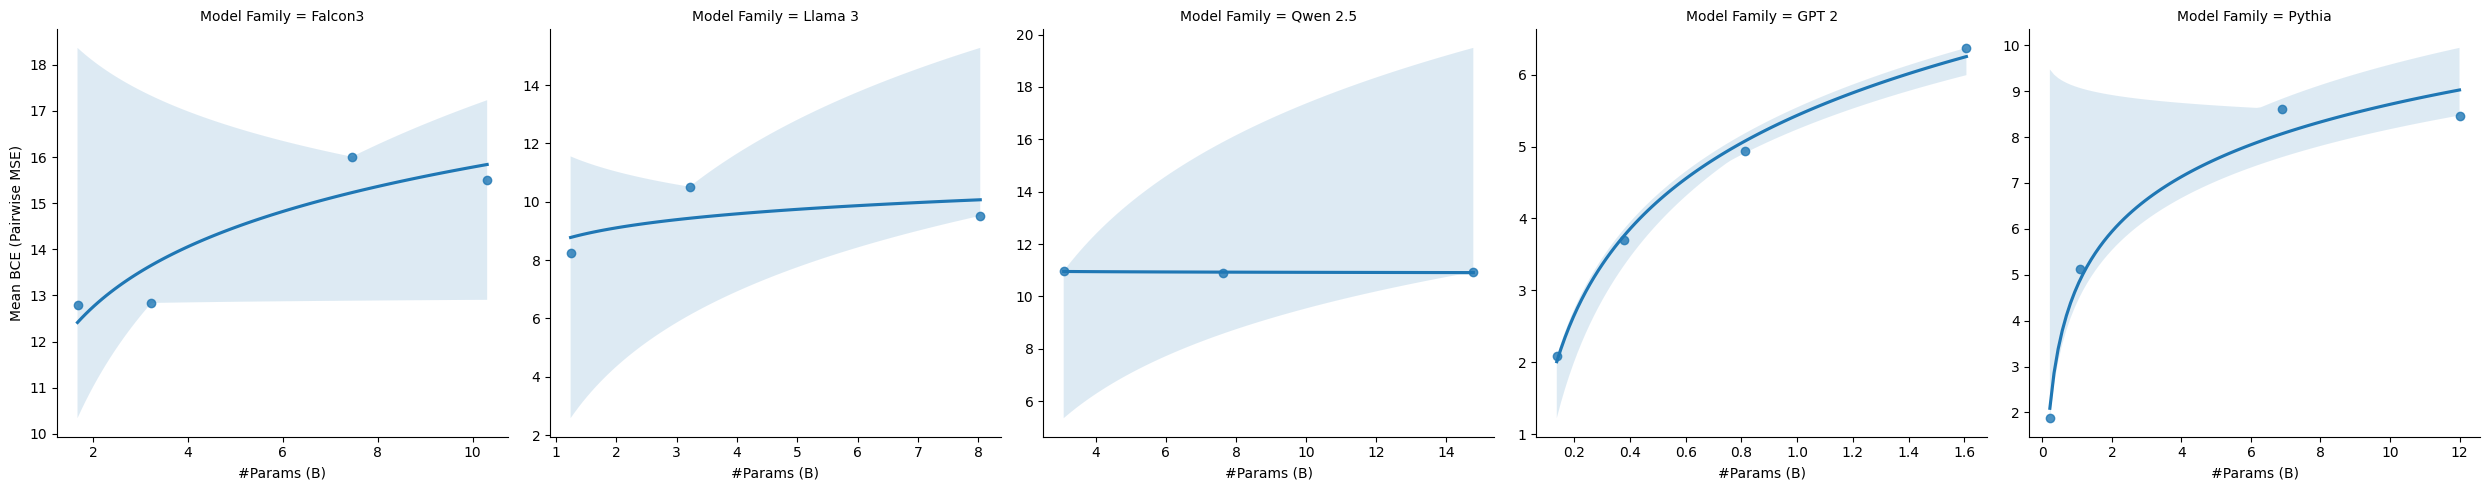

In [91]:
import seaborn as sns

plt = sns.lmplot(
    data=mean_bce_mse_analyzer.df,
    x="#Params (B)",
    y="Mean BCE (Pairwise MSE)",
    col="Model Family",
    logx=True,
    facet_kws={"sharex": False, "sharey": False},
)

## Plotting with matplotlib

Unfortunately, seaborn only allows for linear fits, which appear curved in the log scale plot. We can use matplotlib to fit a log-linear model.

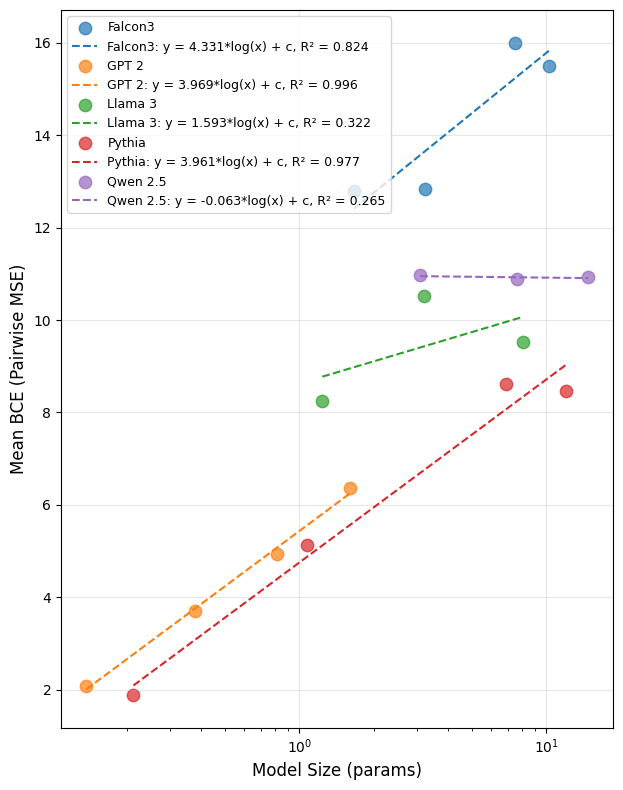

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Function to fit log-linear model
def log_linear_fit(data, x_col, y_col, model_family=None):
    if model_family:
        data = data[data["Model Family"] == model_family]

    x = np.log10(data[x_col])  # Log transform x values
    y = data[y_col]

    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Calculate line
    x_range = np.linspace(min(x), max(x), 100)
    y_range = slope * x_range + intercept

    # Transform x back to original scale for plotting
    x_range_original = 10**x_range

    return x_range_original, y_range, r_value**2, slope


# Create plots with fitted log-linear relationships
plt.figure(figsize=(12, 8))
for i, (analyzer, title) in enumerate(
    [
        (mean_bce_mse_analyzer, "Mean BCE (Pairwise MSE)"),
    ]
):
    plt.subplot(1, 2, i + 1)

    # Plot points
    for model_family in np.unique(analyzer.df["Model Family"]):
        family_data = analyzer.df[analyzer.df["Model Family"] == model_family]
        plt.scatter(
            family_data["#Params (B)"],
            family_data[title],
            label=model_family,
            alpha=0.7,
            s=80,
        )

        # Add fitted line
        x_line, y_line, r2, slope = log_linear_fit(family_data, "#Params (B)", title)
        plt.plot(
            x_line,
            y_line,
            "--",
            label=f"{model_family}: y = {slope:.3f}*log(x) + c, R² = {r2:.3f}",
        )

    plt.xscale("log")
    plt.xlabel("Model Size (params)", fontsize=12)
    plt.ylabel(title, fontsize=12)
    plt.legend(fontsize=9, loc="best")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

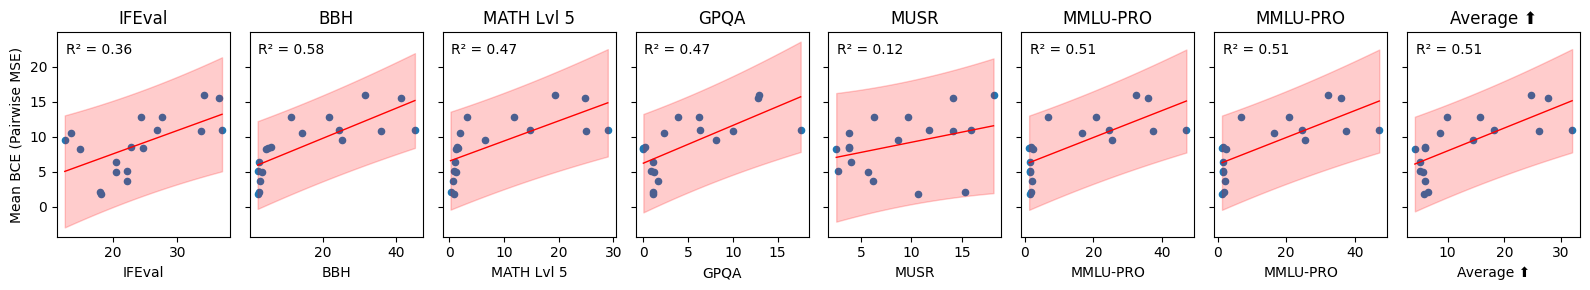

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

for df in [mean_bce_mse_analyzer.df]:
    # Get the column name for the y-axis
    y = [col for col in df.columns if col.startswith("Mean BCE")][0]
    fig, axes = plt.subplots(1, len(selected_evals), figsize=(16, 3), sharey=True)
    for i, metric in enumerate(selected_evals):
        # Create scatter plot
        df.plot.scatter(x=metric, y=y, ax=axes[i], title=metric)

        # Add line of best fit and confidence interval
        mask = ~np.isnan(df[metric]) & ~np.isnan(df[y])  # Filter out NaN values
        if sum(mask) > 1:  # Need at least 2 points for a line
            x = df[metric][mask]
            y_data = df[y][mask]

            # Calculate line of best fit
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y_data)
            line_x = np.linspace(min(x), max(x), 100)
            line_y = intercept + slope * line_x

            # Plot the line
            axes[i].plot(line_x, line_y, "r-", linewidth=1)

            # Calculate confidence interval
            # Get the mean x value
            mean_x = np.mean(x)
            # Sum of squares of x deviations
            n = len(x)
            if n > 2:  # Need at least 3 points for confidence interval
                # Calculate prediction interval
                # Degrees of freedom
                df_res = n - 2
                # Mean square error
                mse = np.sum((y_data - (intercept + slope * x)) ** 2) / df_res
                # Calculate standard error of the regression
                se = np.sqrt(
                    mse
                    * (1 + 1 / n + (line_x - mean_x) ** 2 / np.sum((x - mean_x) ** 2))
                )
                # Calculate confidence interval (95%)
                t_val = stats.t.ppf(0.975, df_res)
                ci = t_val * se

                # Plot confidence interval
                axes[i].fill_between(
                    line_x, line_y - ci, line_y + ci, color="r", alpha=0.2
                )

            # Add R² value
            axes[i].text(
                0.05,
                0.95,
                f"R² = {r_value**2:.2f}",
                transform=axes[i].transAxes,
                verticalalignment="top",
            )

        if i > 0:
            axes[i].set_ylabel("")
    plt.tight_layout()

In [132]:
bce_mse_analyzer.df

mean_bce_mse_category_analyzer = bce_mse_analyzer.calculate_metric(
    metric_func="mean",
    group_by_cols=["Language Model", "class_category"],
    metric_col="BCE (Pairwise MSE)",
    metric_name="Mean BCE (Pairwise MSE)",
    inherit_identical_values=True,
)

mean_bce_mse_category_analyzer.df

,Language Model,class_category,Mean BCE (Pairwise MSE),Training Steps,item_index,class_elicitation,evidence_elicitation,model_provider,temperature,device,model_params,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family
0,Falcon3-10B-Base,airlines,6.160824,unknown,9,I usually fly with,I prefer an airline that offers,hf,1.0,cuda,"{""batch_size"": 16}",10.306,36.477546,41.375462,24.924471,12.751678,14.173958,36.003989,27.617851,Falcon3
1,Falcon3-10B-Base,architectural_styles,18.855095,unknown,1,My favourite architectural style is,I am drawn to,hf,1.0,cuda,"{""batch_size"": 16}",10.306,36.477546,41.375462,24.924471,12.751678,14.173958,36.003989,27.617851,Falcon3
2,Falcon3-10B-Base,culinary_techniques,19.010043,unknown,3,My preferred technique is,I love the results of,hf,1.0,cuda,"{""batch_size"": 16}",10.306,36.477546,41.375462,24.924471,12.751678,14.173958,36.003989,27.617851,Falcon3
3,Falcon3-10B-Base,financial_strategies,17.930178,unknown,5,My preferred strategy is,I focus on,hf,1.0,cuda,"{""batch_size"": 16}",10.306,36.477546,41.375462,24.924471,12.751678,14.173958,36.003989,27.617851,Falcon3
4,Falcon3-10B-Base,formula_1_drivers,6.004489,unknown,0,My favourite Formula 1 driver is,I am most impressed by,hf,1.0,cuda,"{""batch_size"": 16}",10.306,36.477546,41.375462,24.924471,12.751678,14.173958,36.003989,27.617851,Falcon3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,pythia-6.9b,school_of_philosophy,11.671868,143k,8,My preferred school is,I agree with,hf,1.0,cuda,"{""batch_size"": 32}",6.900,22.811363,5.881632,1.435045,0.223714,3.814844,1.632683,5.966547,Pythia
176,pythia-6.9b,state_of_mind,5.110871,143k,2,My current state is,I feel,hf,1.0,cuda,"{""batch_size"": 32}",6.900,22.811363,5.881632,1.435045,0.223714,3.814844,1.632683,5.966547,Pythia
177,pythia-6.9b,superheroes,9.760461,143k,6,My favourite hero is,I admire,hf,1.0,cuda,"{""batch_size"": 32}",6.900,22.811363,5.881632,1.435045,0.223714,3.814844,1.632683,5.966547,Pythia
178,pythia-6.9b,tech_innovators,10.790869,143k,4,My favourite innovator is,I admire,hf,1.0,cuda,"{""batch_size"": 32}",6.900,22.811363,5.881632,1.435045,0.223714,3.814844,1.632683,5.966547,Pythia


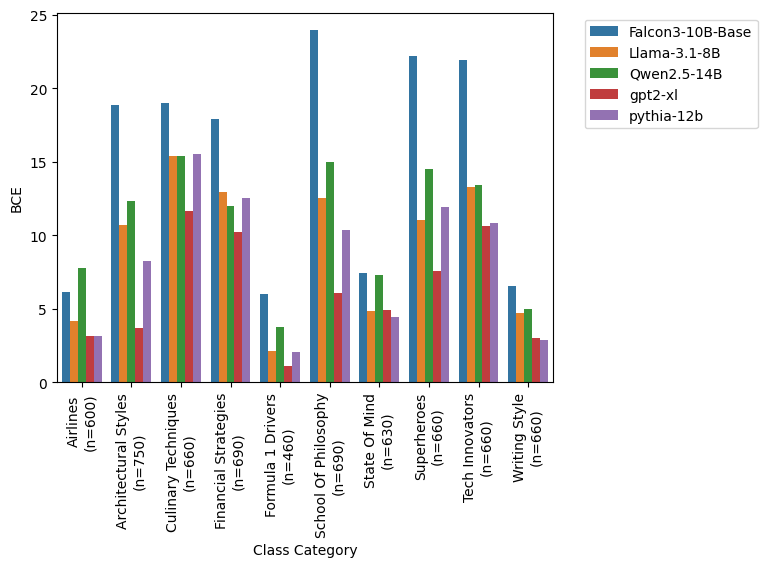

In [ ]:
import seaborn as sns

# Select the largest model per family using #Params (B)
idx = df.groupby('Model Family')['#Params (B)'].idxmax()
largest_models = df.loc[idx]

families = largest_models['Model Family'].unique()

# Step 1: Calculate counts from the original df
counts = (
    bce_mse_analyzer.df
    .groupby(['Language Model', 'class_category'])
    .size()
    .reset_index(name='n')
)

# Step 2: Merge counts into the mean df
df = mean_bce_mse_category_analyzer.df.copy()
df = df.merge(counts, on=['Language Model', 'class_category'], how='left')

def normalize_category(cat):
    # Example normalization: replace underscores with spaces and capitalize each word
    return cat.replace('_', ' ').title()

df['category_with_n'] = df['class_category'].apply(normalize_category) + '\n(n=' + df['n'].astype(str) + ')'

largest_model_names = largest_models['Language Model']
df = df[df['Language Model'].isin(largest_model_names)]

sns.barplot(data=df, x='category_with_n', y='Mean BCE (Pairwise MSE)', hue='Language Model')
plt.xlabel('Class Category')
plt.xticks(rotation=90)
plt.ylabel('BCE')
plt.legend(title='Model')
plt.show()

# BCE across training steps (pythia models only)

In [ ]:
pythia_data_analyzer = data_analyzer

pythia_data_analyzer.filter({"Model Family": ["Pythia"]})

pythia_data_analyzer.df[["Training Steps", "Language Model"]].drop_duplicates()


,Training Steps,Language Model
51680,33k,pythia-160m
54910,66k,pythia-160m
58140,99k,pythia-160m
61370,143k,pythia-160m
64600,33k,pythia-1b
67830,66k,pythia-1b
71060,99k,pythia-1b
74290,143k,pythia-1b
77520,33k,pythia-6.9b
80750,66k,pythia-6.9b


In [ ]:
pythia_bce_mse_analyzer = pythia_data_analyzer.calculate_metric(
    metric_name="BCE (Pairwise MSE)",
    metric_func=pairwise_bce_of_group,
    group_by_cols=[
        "evidence_text",
        "class_category",
        "Language Model",
        "Training Steps",
        "conversation_history"
    ],
    log_prior_col="prior_logprob",
    log_likelihood_col="likelihood_logprob",
    log_posterior_col="posterior_logprob",
    square=True,
    inherit_identical_values=True,
)


mean_pythia_bce_mse_analyzer = pythia_bce_mse_analyzer.calculate_metric(
    metric_func="mean",
    group_by_cols=["Language Model", "Training Steps"],
    metric_col="BCE (Pairwise MSE)",
    metric_name="Mean BCE (Pairwise MSE)",
    inherit_identical_values=True,
)

# Set sort order using the *new* names
mean_pythia_bce_mse_analyzer.sort(
    {
        "#Params (B)": lambda x: x,
        "Training Steps": [
            "33k",
            "66k",
            "99k",
            "143k",
            "unknown",
        ],
    }
)

mean_pythia_bce_mse_analyzer.df

,Language Model,Training Steps,Mean BCE (Pairwise MSE),model_provider,temperature,device,model_params,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family
5,pythia-160m,33k,2.140884,hf,1.0,cuda,"{""batch_size"": 32}",0.213,18.155162,2.198832,0.906344,1.118568,10.675521,1.327940,5.730395,Pythia
6,pythia-160m,66k,2.147770,hf,1.0,cuda,"{""batch_size"": 32}",0.213,18.155162,2.198832,0.906344,1.118568,10.675521,1.327940,5.730395,Pythia
7,pythia-160m,99k,2.153788,hf,1.0,cuda,"{""batch_size"": 32}",0.213,18.155162,2.198832,0.906344,1.118568,10.675521,1.327940,5.730395,Pythia
4,pythia-160m,143k,1.874455,hf,1.0,cuda,"{""batch_size"": 32}",0.213,18.155162,2.198832,0.906344,1.118568,10.675521,1.327940,5.730395,Pythia
9,pythia-1b,33k,5.158689,hf,1.0,cuda,"{""batch_size"": 32}",1.079,22.079416,2.293986,0.906344,0.894855,2.734375,1.512633,5.070268,Pythia
10,pythia-1b,66k,4.539813,hf,1.0,cuda,"{""batch_size"": 32}",1.079,22.079416,2.293986,0.906344,0.894855,2.734375,1.512633,5.070268,Pythia
11,pythia-1b,99k,5.141691,hf,1.0,cuda,"{""batch_size"": 32}",1.079,22.079416,2.293986,0.906344,0.894855,2.734375,1.512633,5.070268,Pythia
8,pythia-1b,143k,5.121756,hf,1.0,cuda,"{""batch_size"": 32}",1.079,22.079416,2.293986,0.906344,0.894855,2.734375,1.512633,5.070268,Pythia
13,pythia-6.9b,33k,7.478295,hf,1.0,cuda,"{""batch_size"": 32}",6.900,22.811363,5.881632,1.435045,0.223714,3.814844,1.632683,5.966547,Pythia
14,pythia-6.9b,66k,7.536695,hf,1.0,cuda,"{""batch_size"": 32}",6.900,22.811363,5.881632,1.435045,0.223714,3.814844,1.632683,5.966547,Pythia


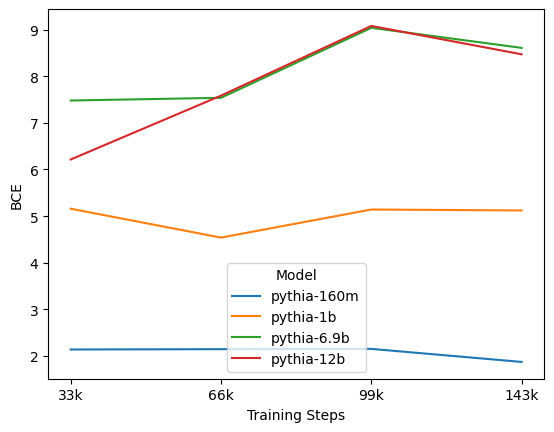

In [ ]:
import seaborn as sns

sns.lineplot(data=mean_pythia_bce_mse_analyzer.df, x='Training Steps', y='Mean BCE (Pairwise MSE)', hue='Language Model')
plt.xlabel('Training Steps')
plt.ylabel('BCE')
plt.legend(title='Model')
plt.show()